This code is used to generate a new data input file that handles all of the feature engineering for this project.  The data has a mix of numeric and non-numeric fields.  The main purpose of this process is to encode all non-numeric fields, as well as consolidate some of the values in those fields.  This process will (hopefully) make those fields more meaningful.

In [0]:
#I used Google Colab to build and run my network
#It provides free TPU resources, making it much less time consuming than trying to run this on my machine
#This section give my notebook access to my Google Drive to import the training data, where I have saved it


from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from string import punctuation
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler



In [0]:
#set styles
plt.style.use('seaborn')
sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [8,8]
pd.set_option('max_columns',100) #show more columns
encoding = LabelEncoder()



In [0]:
#import training data

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv', low_memory = False)

In [0]:
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


## Data Summary

- There are 22 players on the field each play, 11 for each team. 
- Every row shows what each player is doing on a single play.
- Each play has a unique id that can be used to group the data
- The goal is to predict how many yards a player will run for after receiving the ball (the handoff).

Look first at the target variable, rushing yards.

In [0]:
data['Yards'].describe()

count    509762.000000
mean          4.212334
std           6.436167
min         -14.000000
25%           1.000000
50%           3.000000
75%           6.000000
max          99.000000
Name: Yards, dtype: float64

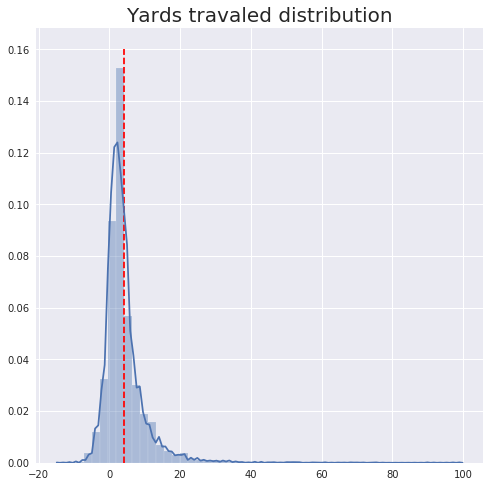

In [0]:
ax = sns.distplot(data['Yards'])
plt.vlines(data['Yards'].mean(), plt.ylim()[0], plt.ylim()[1], color='r', linestyles='--');
plt.xlabel("")
plt.title("Yards travaled distribution", size=20);

# Find all Categorical Features

In [0]:
categorical = []
for x in data.columns:
    if data[x].dtype =='object':
        categorical.append((x, len(data[x].unique())))

In [0]:
categorical

[('Team', 2),
 ('DisplayName', 2230),
 ('GameClock', 901),
 ('PossessionTeam', 32),
 ('FieldPosition', 33),
 ('OffenseFormation', 9),
 ('OffensePersonnel', 56),
 ('DefensePersonnel', 38),
 ('PlayDirection', 2),
 ('TimeHandoff', 22935),
 ('TimeSnap', 22943),
 ('PlayerHeight', 16),
 ('PlayerBirthDate', 1688),
 ('PlayerCollegeName', 301),
 ('Position', 25),
 ('HomeTeamAbbr', 32),
 ('VisitorTeamAbbr', 32),
 ('Stadium', 55),
 ('Location', 60),
 ('StadiumType', 30),
 ('Turf', 20),
 ('GameWeather', 62),
 ('WindSpeed', 41),
 ('WindDirection', 54)]

# Clean Stadium Type

In [0]:
data['StadiumType'].value_counts()

Outdoor                   267696
Outdoors                   67474
Indoors                    40854
Dome                       17336
Indoor                     16148
Retractable Roof           15884
Open                        9614
Retr. Roof-Closed           7172
Retr. Roof - Closed         6446
Domed, closed               5918
Domed, open                 2684
Closed Dome                 2134
Dome, closed                1826
Domed                       1826
Oudoor                      1188
Retr. Roof Closed           1056
Indoor, Roof Closed         1056
Retr. Roof-Open              990
Outddors                     968
Bowl                         968
Heinz Field                  902
Retr. Roof - Open            880
Outdoor Retr Roof-Open       880
Outdor                       858
Indoor, Open Roof            858
Ourdoor                      858
Outside                      814
Cloudy                       770
Domed, Open                  770
Name: StadiumType, dtype: int64

In [0]:
#consolidate stadium types to either outdoor/open or indoor/closed

def Stadium_clean(stad_type):
    if pd.isna(stad_type):
        return np.nan
    stad_type = stad_type.lower()
    txt = ''.join([c for c in stad_type if c not in punctuation])
    stad_type = re.sub(' +', ' ', stad_type)
    stad_type = stad_type.strip()
    stad_type = stad_type.replace('outside', 'outdoor')
    stad_type = stad_type.replace('outdor', 'outdoor')
    stad_type = stad_type.replace('outddors', 'outdoor')
    stad_type = stad_type.replace('outdoors', 'outdoor')
    stad_type = stad_type.replace('oudoor', 'outdoor')
    stad_type = stad_type.replace('indoors', 'indoor')
    stad_type = stad_type.replace('ourdoor', 'outdoor')
    stad_type = stad_type.replace('retractable', 'rtr.')
    return stad_type

data['StadiumType'] = data['StadiumType'].apply(Stadium_clean)

def Stadium_encode(stadium):
    if pd.isna(stadium):
        return np.nan
    if 'outdoor' in stadium or 'open' in stadium:
        return 1
    if 'indoor' in stadium or 'closed' in stadium:
        return 0
    return np.nan

data['StadiumType'] = data['StadiumType'].apply(Stadium_encode)

In [0]:
data['StadiumType'].value_counts()

1.0    356532
0.0     82610
Name: StadiumType, dtype: int64

# Type of Field

In [0]:
data['Turf'].value_counts()

Grass                     166276
Natural Grass             107096
Field Turf                 47674
Artificial                 44484
FieldTurf                  33198
UBU Speed Series-S5-M      32890
A-Turf Titan               17204
UBU Sports Speed S5-M       8558
FieldTurf360                8272
DD GrassMaster              8074
Twenty-Four/Seven Turf      8030
SISGrass                    7238
FieldTurf 360               6974
Natural grass               4796
Artifical                   3894
Natural                     1628
Field turf                   990
Naturall Grass               858
grass                        814
natural grass                814
Name: Turf, dtype: int64

In [0]:
#encode Turf types to either natural (1) or turf (0)

def turf_encode(turf):
    turf = turf.lower()
    if pd.isna(turf):
        return np.nan
    if 'grass' in turf or 'natural' in turf:
        return 1
    return 0

In [0]:
data['Turf'] = data['Turf'].apply(turf_encode)

In [0]:
data['Turf'].value_counts()

1    297594
0    212168
Name: Turf, dtype: int64

## Clean up team related information

- encode Home/Away
- Make sure all team abbreviations are the same

In [0]:
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,Clear and warm,63.0,77.0,8,SW


In [0]:
#create dictionary to map Team field values to 0 or 1
#home = 0, away = 1

Team = {'home':0, 'away':1}
data['Team'] = data['Team'].map(Team)

In [0]:
#what team abbreviations don't match?
abbr = []
for i, j in zip(sorted(data['PossessionTeam'].unique()), sorted(data['HomeTeamAbbr'].unique())):
    if i != j:
        print(i + ' ' + j)

ARZ ARI
BLT BAL
CLV CLE
HST HOU


In [0]:
data['PossessionTeam'].unique()

array(['NE', 'KC', 'BUF', 'NYJ', 'ATL', 'CHI', 'CIN', 'BLT', 'CLV', 'PIT',
       'ARZ', 'DET', 'JAX', 'HST', 'OAK', 'TEN', 'WAS', 'PHI', 'LA',
       'IND', 'SEA', 'GB', 'CAR', 'SF', 'DAL', 'NYG', 'NO', 'MIN', 'DEN',
       'LAC', 'TB', 'MIA'], dtype=object)

In [0]:
abbr = {'ARZ':'ARI', 'BLT':'BAL', 'CLV':'CLE', 'HST':'HOU'}
for abb in data['PossessionTeam'].unique():
    abbr[abb] = abb

In [0]:
#clean up these four team abbreviations

abbr = {'ARZ':'ARI', 'BLT':'BAL', 'CLV':'CLE', 'HST':'HOU'}

for abb in data['PossessionTeam'].unique():
    abbr[abb] = abb

data['PossessionTeam'] = data['PossessionTeam'].map(abbr)
data['HomeTeamAbbr'] = data['HomeTeamAbbr'].map(abbr)
data['VisitorTeamAbbr'] = data['VisitorTeamAbbr'].map(abbr)
data['FieldPosition'] = data['FieldPosition'].map(abbr)

## Make Adjustments for field position and game clock
- Make a new field showing the yards remaining to the end zone based on field position
- If field position = possession team, they are closer to the endzone. 
- Each quarter is 15 minutes long.  Quarter is provided so Game clock will be divided by 15 to get a percentage value of much of each quarter is completed

Make updates to Field Position.  If FieldPosition == PossessionTeam then 1, otherwise 0.

In [0]:
#Create yards to endzone field
data['YardstoEndZone'] = data.apply(lambda x: 100-x['YardLine'] if x['PossessionTeam'] == x['FieldPosition'] else x['YardLine'], axis=1)


Make adjustments to the game clock

In [0]:
#convert game time to seconds
#will use a scaler to normalize later
def gameclock(clock):
    clock = clock.split(':')
    adj = int(clock[0])*60 + int(clock[1]) + int(clock[2])/60
    return adj

data['GameClock'] = data['GameClock'].apply(gameclock)



In [0]:
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,YardstoEndZone
0,2017090700,20170907000118,1,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,Clear and warm,63.0,77.0,8,SW,65
1,2017090700,20170907000118,1,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,Clear and warm,63.0,77.0,8,SW,65
2,2017090700,20170907000118,1,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,Clear and warm,63.0,77.0,8,SW,65
3,2017090700,20170907000118,1,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,Clear and warm,63.0,77.0,8,SW,65
4,2017090700,20170907000118,1,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,Clear and warm,63.0,77.0,8,SW,65


## Adjust Weather data

In [0]:
data['GameWeather'].value_counts()

Cloudy                                  114466
Sunny                                   105028
Partly Cloudy                            46068
Clear                                    44264
Rain                                     18898
                                         ...  
Cloudy, light snow accumulating 1-3"       836
Party Cloudy                               814
Sunny, Windy                               792
Partly clear                               770
Rainy                                      704
Name: GameWeather, Length: 61, dtype: int64

In [0]:
#pair down weather types to just 2 options and label them with numbers
#precipitation = 0, everything else = 1
def Weather_clean(weather):
    if pd.isna(weather):
        return np.nan
    weather = weather.lower()
    weather = weather.replace('coudy', 'cloudy')
    weather = weather.replace('hazy', 'cloudy')
    weather = weather.replace('overcast', 'cloudy')
    weather = weather.replace('clouidy', 'cloudy')
    if 'snow' in weather or 'rain' in weather or 'showers' in weather:
        return 0
    return 1

data['GameWeather'] = data['GameWeather'].apply(Weather_clean)

In [0]:
data['GameWeather'].value_counts()

1.0    428824
0.0     37290
Name: GameWeather, dtype: int64

In [0]:
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,YardstoEndZone
0,2017090700,20170907000118,1,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,1.0,63.0,77.0,8,SW,65
1,2017090700,20170907000118,1,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,1.0,63.0,77.0,8,SW,65
2,2017090700,20170907000118,1,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,1.0,63.0,77.0,8,SW,65
3,2017090700,20170907000118,1,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,1.0,63.0,77.0,8,SW,65
4,2017090700,20170907000118,1,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,1.0,63.0,77.0,8,SW,65


## Fix player heights
- Coming over as Feet-Inches 
- Need to convert to inches only

In [0]:
data['PlayerHeight'].value_counts()

6-3     81694
6-4     66603
6-5     62913
6-1     61729
6-2     52893
6-0     50531
5-11    39361
6-6     34650
5-10    24596
6-7     13076
5-9      9439
6-8      5653
5-8      3507
6-9      2029
5-7       682
5-6       406
Name: PlayerHeight, dtype: int64

In [0]:
data['PlayerHeight'] = data['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

## Time of Snap to Handoff

In [0]:
data['TimeToHandoff'] = (pd.to_datetime(data['TimeHandoff']) - \
                               pd.to_datetime(data['TimeSnap'])).dt.total_seconds()

## Make final encodings

In [0]:
#One-hot encode offensive formation
data = pd.concat([data.drop(['OffenseFormation'], axis=1), pd.get_dummies(data['OffenseFormation'], prefix='Formation')], axis=1)


In [0]:
#one-hot encode offense personnel
data = pd.concat([data.drop(['OffensePersonnel'], axis=1), pd.get_dummies(data['OffensePersonnel'], prefix='Off_Pers')], axis=1)

In [0]:
#one-hot encode play direction
data = pd.concat([data.drop(['PlayDirection'], axis=1), pd.get_dummies(data['PlayDirection'], prefix='Direction')], axis=1)

In [0]:
#One-hot encode defensive formation
data = pd.concat([data.drop(['DefensePersonnel'], axis=1), pd.get_dummies(data['DefensePersonnel'], prefix='Formation')], axis=1)

In [0]:
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,YardstoEndZone,TimeToHandoff,Formation_ACE,Formation_EMPTY,Formation_I_FORM,...,"Off_Pers_6 OL, 1 RB, 3 TE, 0 WR","Off_Pers_6 OL, 2 RB, 0 TE, 2 WR","Off_Pers_6 OL, 2 RB, 1 TE, 0 WR,1 DL","Off_Pers_6 OL, 2 RB, 1 TE, 1 WR","Off_Pers_6 OL, 2 RB, 2 TE, 0 WR","Off_Pers_6 OL, 3 RB, 0 TE, 1 WR","Off_Pers_7 OL, 1 RB, 0 TE, 2 WR","Off_Pers_7 OL, 1 RB, 2 TE, 0 WR","Off_Pers_7 OL, 2 RB, 0 TE, 1 WR","Off_Pers_7 OL, 2 RB, 1 TE, 0 WR",Direction_left,Direction_right,"Formation_0 DL, 4 LB, 7 DB","Formation_0 DL, 5 LB, 6 DB","Formation_0 DL, 6 LB, 5 DB","Formation_1 DL, 2 LB, 8 DB","Formation_1 DL, 3 LB, 7 DB","Formation_1 DL, 4 LB, 6 DB","Formation_1 DL, 5 LB, 5 DB","Formation_2 DL, 2 LB, 7 DB","Formation_2 DL, 3 LB, 6 DB","Formation_2 DL, 4 LB, 4 DB, 1 OL","Formation_2 DL, 4 LB, 5 DB","Formation_2 DL, 5 LB, 4 DB","Formation_3 DL, 1 LB, 7 DB","Formation_3 DL, 2 LB, 6 DB","Formation_3 DL, 3 LB, 5 DB","Formation_3 DL, 4 LB, 3 DB, 1 OL","Formation_3 DL, 4 LB, 4 DB","Formation_3 DL, 5 LB, 3 DB","Formation_4 DL, 0 LB, 7 DB","Formation_4 DL, 1 LB, 6 DB","Formation_4 DL, 2 LB, 5 DB","Formation_4 DL, 3 LB, 4 DB","Formation_4 DL, 4 LB, 3 DB","Formation_4 DL, 5 LB, 1 DB, 1 OL","Formation_4 DL, 5 LB, 2 DB","Formation_4 DL, 6 LB, 1 DB","Formation_5 DL, 1 LB, 5 DB","Formation_5 DL, 2 LB, 4 DB","Formation_5 DL, 3 LB, 2 DB, 1 OL","Formation_5 DL, 3 LB, 3 DB","Formation_5 DL, 4 LB, 1 DB, 1 OL","Formation_5 DL, 4 LB, 2 DB","Formation_5 DL, 5 LB, 1 DB","Formation_6 DL, 1 LB, 4 DB","Formation_6 DL, 2 LB, 3 DB","Formation_6 DL, 3 LB, 2 DB","Formation_6 DL, 4 LB, 1 DB","Formation_7 DL, 2 LB, 2 DB"
0,2017090700,20170907000118,1,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,72,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,1.0,63.0,77.0,8,SW,65,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017090700,20170907000118,1,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,75,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,1.0,63.0,77.0,8,SW,65,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017090700,20170907000118,1,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,75,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,1.0,63.0,77.0,8,SW,65,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017090700,20170907000118,1,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,75,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,1.0,63.0,77.0,8,SW,65,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017090700,20170907000118,1,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,72,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,0,1.0,63.0,77.0,8,SW,65,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0

## Convert data frame to one row per play

In [0]:
categorical = []
for col in data.columns:
    if data[col].dtype =='object':
        categorical.append(col)

data = data.drop(categorical, axis = 1)

In [0]:
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,GameClock,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,Yards,PlayerHeight,PlayerWeight,Week,StadiumType,Turf,GameWeather,Temperature,Humidity,YardstoEndZone,TimeToHandoff,Formation_ACE,Formation_EMPTY,Formation_I_FORM,Formation_JUMBO,Formation_PISTOL,Formation_SHOTGUN,Formation_SINGLEBACK,Formation_WILDCAT,"Off_Pers_0 RB, 0 TE, 5 WR","Off_Pers_0 RB, 1 TE, 4 WR","Off_Pers_0 RB, 2 TE, 3 WR","Off_Pers_0 RB, 3 TE, 2 WR","Off_Pers_1 RB, 0 TE, 3 WR,1 DB","Off_Pers_1 RB, 0 TE, 4 WR","Off_Pers_1 RB, 1 TE, 2 WR,1 DB","Off_Pers_1 RB, 1 TE, 2 WR,1 DL","Off_Pers_1 RB, 1 TE, 2 WR,1 LB",...,"Off_Pers_6 OL, 1 RB, 3 TE, 0 WR","Off_Pers_6 OL, 2 RB, 0 TE, 2 WR","Off_Pers_6 OL, 2 RB, 1 TE, 0 WR,1 DL","Off_Pers_6 OL, 2 RB, 1 TE, 1 WR","Off_Pers_6 OL, 2 RB, 2 TE, 0 WR","Off_Pers_6 OL, 3 RB, 0 TE, 1 WR","Off_Pers_7 OL, 1 RB, 0 TE, 2 WR","Off_Pers_7 OL, 1 RB, 2 TE, 0 WR","Off_Pers_7 OL, 2 RB, 0 TE, 1 WR","Off_Pers_7 OL, 2 RB, 1 TE, 0 WR",Direction_left,Direction_right,"Formation_0 DL, 4 LB, 7 DB","Formation_0 DL, 5 LB, 6 DB","Formation_0 DL, 6 LB, 5 DB","Formation_1 DL, 2 LB, 8 DB","Formation_1 DL, 3 LB, 7 DB","Formation_1 DL, 4 LB, 6 DB","Formation_1 DL, 5 LB, 5 DB","Formation_2 DL, 2 LB, 7 DB","Formation_2 DL, 3 LB, 6 DB","Formation_2 DL, 4 LB, 4 DB, 1 OL","Formation_2 DL, 4 LB, 5 DB","Formation_2 DL, 5 LB, 4 DB","Formation_3 DL, 1 LB, 7 DB","Formation_3 DL, 2 LB, 6 DB","Formation_3 DL, 3 LB, 5 DB","Formation_3 DL, 4 LB, 3 DB, 1 OL","Formation_3 DL, 4 LB, 4 DB","Formation_3 DL, 5 LB, 3 DB","Formation_4 DL, 0 LB, 7 DB","Formation_4 DL, 1 LB, 6 DB","Formation_4 DL, 2 LB, 5 DB","Formation_4 DL, 3 LB, 4 DB","Formation_4 DL, 4 LB, 3 DB","Formation_4 DL, 5 LB, 1 DB, 1 OL","Formation_4 DL, 5 LB, 2 DB","Formation_4 DL, 6 LB, 1 DB","Formation_5 DL, 1 LB, 5 DB","Formation_5 DL, 2 LB, 4 DB","Formation_5 DL, 3 LB, 2 DB, 1 OL","Formation_5 DL, 3 LB, 3 DB","Formation_5 DL, 4 LB, 1 DB, 1 OL","Formation_5 DL, 4 LB, 2 DB","Formation_5 DL, 5 LB, 1 DB","Formation_6 DL, 1 LB, 4 DB","Formation_6 DL, 2 LB, 3 DB","Formation_6 DL, 3 LB, 2 DB","Formation_6 DL, 4 LB, 1 DB","Formation_7 DL, 2 LB, 2 DB"
0,2017090700,20170907000118,1,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,29,2017,35,1,854.0,3,2,0,0,2543773,6.0,8,72,212,1,1.0,0,1.0,63.0,77.0,65,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017090700,20170907000118,1,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,97,2017,35,1,854.0,3,2,0,0,2543773,6.0,8,75,288,1,1.0,0,1.0,63.0,77.0,65,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017090700,20170907000118,1,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,50,2017,35,1,854.0,3,2,0,0,2543773,6.0,8,75,270,1,1.0,0,1.0,63.0,77.0,65,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017090700,20170907000118,1,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,56,2017,35,1,854.0,3,2,0,0,2543773,6.0,8,75,245,1,1.0,0,1.0,63.0,77.0,65,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017090700,20170907000118,1,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,38,2017,35,1,854.0,3,2,0,0,2543773,6.0,8,72,206,1,1.0,0,1.0,63.0,77.0,65,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
data.fillna(-999, inplace=True)

players = []
for i in data.columns:
    if data[i][:22].std()!=0:
        players.append(i)

In [0]:
features = np.array(data[players]).reshape(-1, len(players)*22)

In [0]:
plays = data.drop(players+['Yards'], axis=1).columns
X_plays = np.zeros(shape=(features.shape[0], len(plays)))
for i, col in enumerate(plays):
    X_plays[:, i] = data[col][::22]

In [0]:
#create input array
features = np.concatenate([features, X_plays], axis=1)


In [0]:
#create output density table
output = np.zeros(shape=(features.shape[0], 199))
for i,yard in enumerate(data['Yards'][::22]):
    output[i, yard+99:] = np.ones(shape=(1, 100-yard))

In [0]:
#create label output array for regression
labels = data[['PlayId', 'Yards']]
reg_output = labels.drop_duplicates(keep = 'first')
reg_output = np.array(reg_output['Yards'])

#reg_output = output.reshape(-1,1)



In [0]:
#Scale all values
scaler = StandardScaler()
features = scaler.fit_transform(features)

#reg_output = scaler.fit_transform(reg_output)


In [0]:
features.shape

(23171, 388)

In [0]:
output.shape

(23171, 199)

In [0]:
reg_output.shape

(23171,)

## Build out Neural Network
- import libraries
- define hyperparameters
- define the network
- run the network

In [0]:
#import libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras import layers
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split as tts, cross_val_score as cvs



Using TensorFlow backend.


In [0]:
#enough with the warnings
import warnings
warnings.filterwarnings(action = 'ignore', category = FutureWarning)
warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)

In [0]:
#create function to build graph that compares train and validation error in the network

def performance(model):
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train','Validation'], loc = 'upper left')
  plt.show()

In [0]:
#build train and test sets for regression
random = 1234

X_reg = features
y_reg = reg_output

Xtrain_reg, Xtest_reg, ytrain_reg, ytest_reg = tts(X_reg, y_reg, test_size = 0.25, random_state = random)

print('Training records =',Xtrain_reg.shape[0])
print('Test records = ', Xtest_reg.shape[0])

Training records = 17378
Test records =  5793


In [0]:
#build train and test sets for probability
random = 1234

X = features
y = output

Xtrain, Xtest, ytrain, ytest = tts(X, y, test_size = 0.25, random_state = random)

print('Training records =',Xtrain.shape[0])
print('Test records = ', Xtest.shape[0])

Training records = 17378
Test records =  5793


In [0]:
#set hyperparameters

lr = 0.001 #learning rate
epochs = 50
batch = 1000
dim = features.shape[1] #total dimensions

optimize = Adam(lr = lr) #optimizer

This section will build the regression network

In [0]:
#build regression model

model_reg = Sequential()
model_reg.add(Dense(dim, input_dim = dim, kernel_initializer='normal', activation='relu'))
model_reg.add(Dense(128, kernel_initializer='normal', activation='relu'))
model_reg.add(Dense(64, kernel_initializer='normal', activation='relu'))
model_reg.add(Dense(32, kernel_initializer='normal', activation='relu'))
model_reg.add(Dense(1))

model_reg.compile(loss = 'mean_squared_error', optimizer = optimize, metrics = ['mse'])

model_reg.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 388)               150932    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               49792     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 211,093
Trainable params: 211,093
Non-trainable params: 0
_________________________________________________________________


In [0]:
#fit the model
reg = model_reg.fit(Xtrain_reg, ytrain_reg, epochs = epochs, batch_size=batch, verbose=1, validation_split= 0.2)

Train on 13902 samples, validate on 3476 samples
Epoch 1/50
13902/13902 [==============================] - 1s 66us/step - loss: 44.1244 - mean_squared_error: 44.1244 - val_loss: 46.0278 - val_mean_squared_error: 46.0278
Epoch 2/50
13902/13902 [==============================] - 0s 35us/step - loss: 37.8694 - mean_squared_error: 37.8694 - val_loss: 45.4906 - val_mean_squared_error: 45.4906
Epoch 3/50
13902/13902 [==============================] - 1s 36us/step - loss: 35.9653 - mean_squared_error: 35.9653 - val_loss: 45.3382 - val_mean_squared_error: 45.3382
Epoch 4/50
13902/13902 [==============================] - 0s 36us/step - loss: 34.9726 - mean_squared_error: 34.9726 - val_loss: 45.6975 - val_mean_squared_error: 45.6975
Epoch 5/50
13902/13902 [==============================] - 0s 35us/step - loss: 33.9230 - mean_squared_error: 33.9230 - val_loss: 46.1435 - val_mean_squared_error: 46.1435
Epoch 6/50
13902/13902 [==============================] - 1s 37us/step - loss: 32.1273 - mean_sq

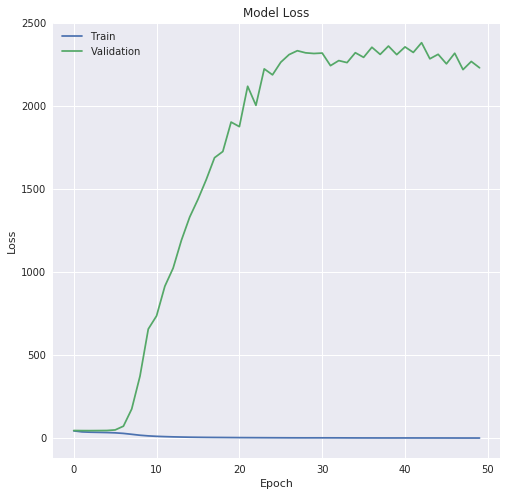

In [0]:
#look at training/validation performance
performance(reg)

In [0]:
#how does the test data perform?
reg_train_scores = model_reg.evaluate(Xtrain_reg, ytrain_reg)
reg_test_scores = model_reg.evaluate(Xtest_reg, ytest_reg)

print('Training Score =',reg_train_scores)
print('Test Score =',reg_test_scores)

5793/5793 [==============================] - 0s 41us/step
Training Score = [446.90922517605816, 446.90922517605816]
Test Score = [1146.216760550841, 1146.216760550841]


In [0]:
#create and measure predictions

reg_predict = model_reg.predict(Xtest_reg, verbose = 0)
mse = np.square(np.subtract(ytest_reg,reg_predict)).mean() 
print('MSE on Test values: {:.2f}'.format(mse))

MSE on Test values: 1147.94


This section will build the different probability networks

In [0]:
#build probability model

model_1 = Sequential()
model_1.add(Dense(dim, input_dim = dim, kernel_initializer='normal', activation='relu'))
model_1.add(Dense(128, kernel_initializer='normal', activation='relu'))
model_1.add(Dense(64, kernel_initializer='normal', activation='relu'))
model_1.add(Dense(32, kernel_initializer='normal', activation='relu'))
model_1.add(Dense(199, kernel_initializer='normal', activation = 'softmax'))

model_1.compile(loss = 'mean_squared_error', optimizer = optimize, metrics = ['mse'])

model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 388)               150932    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               49792     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 199)               6567      
Total params: 217,627
Trainable params: 217,627
Non-trainable params: 0
_________________________________________________________________


In [0]:
#train the model

rushing = model_1.fit(Xtrain, ytrain, epochs = epochs, batch_size=batch, verbose=1, validation_data=(Xtest,ytest))


Train on 17378 samples, validate on 5793 samples
Epoch 1/50
17378/17378 [==============================] - 2s 94us/step - loss: 0.4737 - mean_squared_error: 0.4737 - val_loss: 0.4720 - val_mean_squared_error: 0.4720
Epoch 2/50
17378/17378 [==============================] - 1s 71us/step - loss: 0.4739 - mean_squared_error: 0.4739 - val_loss: 0.4736 - val_mean_squared_error: 0.4736
Epoch 3/50
17378/17378 [==============================] - 1s 66us/step - loss: 0.4723 - mean_squared_error: 0.4723 - val_loss: 0.4715 - val_mean_squared_error: 0.4715
Epoch 4/50
17378/17378 [==============================] - 1s 63us/step - loss: 0.4715 - mean_squared_error: 0.4715 - val_loss: 0.4714 - val_mean_squared_error: 0.4714
Epoch 5/50
17378/17378 [==============================] - 1s 73us/step - loss: 0.4715 - mean_squared_error: 0.4715 - val_loss: 0.4714 - val_mean_squared_error: 0.4714
Epoch 6/50
17378/17378 [==============================] - 1s 73us/step - loss: 0.4715 - mean_squared_error: 0.4715 -

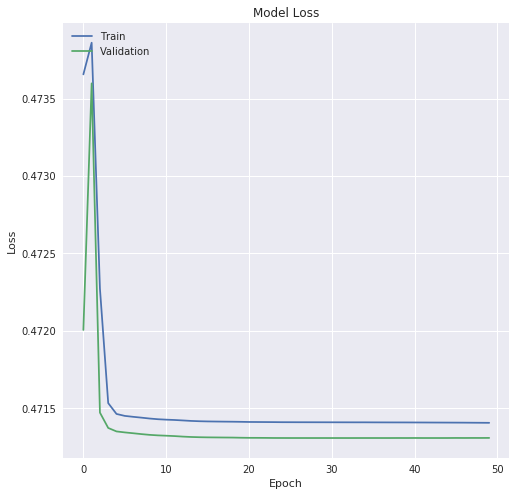

In [0]:
#lets look at how the training performed

performance(rushing)

In [0]:
#training and test scores
mod_1_train_scores = model_1.evaluate(Xtrain, ytrain)
mod_1_test_scores = model_1.evaluate(Xtest, ytest)

print('Training Score = {:.5f}'.format(mod_1_train_scores[0]))
print('Test Score = {:.5f}'.format(mod_1_train_scores[0]))

5793/5793 [==============================] - 0s 47us/step
Training Score = 0.47141
Test Score = 0.47141


**Those results were good, but I'm going to build one with some dropout layers to increase generalization.**

In [0]:
#model #2

model_2 = Sequential()
model_2.add(Dense(dim, input_dim = dim, activation='relu'))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(199))

model_2.compile(loss = 'mean_squared_error', optimizer = optimize, metrics = ['mse'])

model_2.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 388)               150932    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               49792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
____

In [0]:
rushing_2 = model_2.fit(Xtrain, ytrain, epochs = epochs, batch_size=batch, verbose=1, validation_data = (Xtest,ytest))

Train on 17378 samples, validate on 5793 samples
Epoch 1/50
17378/17378 [==============================] - 2s 107us/step - loss: 0.2169 - mean_squared_error: 0.2169 - val_loss: 0.0436 - val_mean_squared_error: 0.0436
Epoch 2/50
17378/17378 [==============================] - 1s 74us/step - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0324 - val_mean_squared_error: 0.0324
Epoch 3/50
17378/17378 [==============================] - 1s 77us/step - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 4/50
17378/17378 [==============================] - 1s 67us/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 5/50
17378/17378 [==============================] - 1s 59us/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Epoch 6/50
17378/17378 [==============================] - 1s 60us/step - loss: 0.0153 - mean_squared_error: 0.0153 

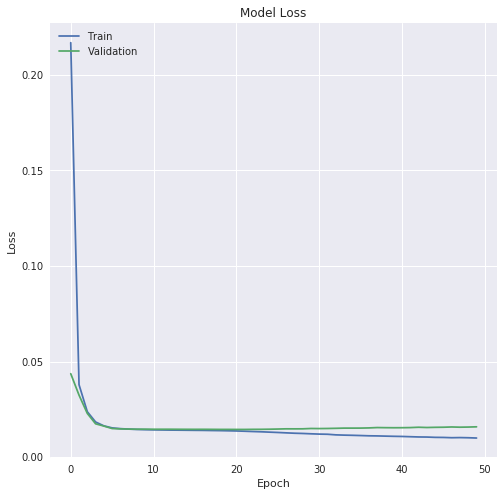

In [0]:
performance(rushing_2)

In [0]:
#training and test scores
mod_2_train_scores = model_2.evaluate(Xtrain, ytrain)
mod_2_test_scores = model_2.evaluate(Xtest, ytest)

print('Training Score = {:.5f}'.format(mod_2_train_scores[0]))
print('Test Score = {:.5f}'.format(mod_2_test_scores[0]))

5793/5793 [==============================] - 0s 49us/step
Training Score = 0.00928
Test Score = 0.01582
